# Cross-asset skewness

This notebook analyses cross-asset cross-sectional skewness strategy. The strategy takes long positions on contracts with most negative historical skewness and short positions on ones with most positive skewness.

In [1]:
%matplotlib inline
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.style.use('bmh')

from vivace.backtest import signal
from vivace.backtest import processing
from vivace.backtest.contract import all_futures_baltas2019
from vivace.backtest.engine import BacktestEngine
from vivace.backtest.enums import Strategy
from vivace.backtest.stats import Performance

# Data

Various futures contracts in commodity, currency, government bond futures and equity index futures are tested. Some contracts are missing in this data set due to data availability.

In [2]:
all_futures_baltas2019

,name,asset_class
ticker,,
LA,Aluminium High Grade,commodity
CO,Brent Crude Oil,commodity
CC,Cocoa,commodity
FC,Coffee C Arabica,commodity
HG,Copper Futures,commodity
C,Corn Futures,commodity
CT,Cotton #2,commodity
CL,Light Sweet Crude Oil Futures,commodity
FC,Feeder Cattle Futures,commodity


In [3]:
all_futures_baltas2019.shape

(52, 2)

# Performance

## Run backtest

For each asset class, a simple portfolio is constructed by using trailing 1-year returns of each futures. Unlike studies in equities, the recent 1-month is included in the formation period. Positions are rebalanced on a monthly basis.

In [4]:
engine_commodity = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=all_futures_baltas2019.query('asset_class == "commodity"').index,
    signal=signal.XSSkewness(lookback=252, 
                             post_process=processing.Pipeline([
                                 processing.Negate(),
                                 processing.AsFreq(freq='m', method='pad')
                             ])),
    log_level=logging.WARN,
)
engine_commodity.run()

In [5]:
commodity_portfolio_return = (engine_commodity.calculate_equity_curve(calculate_net=False)
                              .rename('Commodity skewness portfolio'))

In [6]:
engine_equity = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=all_futures_baltas2019.query('asset_class == "equity"').index,
    signal=signal.XSSkewness(lookback=252, 
                             post_process=processing.Pipeline([
                                 processing.Negate(),
                                 processing.AsFreq(freq='m', method='pad')
                             ])),
    log_level=logging.WARN,
)
engine_equity.run()

In [7]:
equity_portfolio_return = (engine_equity.calculate_equity_curve(calculate_net=False)
                           .rename('Equity skewness portfolio'))

In [8]:
engine_fixed_income = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=all_futures_baltas2019.query('asset_class == "fixed_income"').index,
    signal=signal.XSSkewness(lookback=252, 
                             post_process=processing.Pipeline([
                                 processing.Negate(),
                                 processing.AsFreq(freq='m', method='pad')
                             ])),
    log_level=logging.WARN,
)
engine_fixed_income.run()

In [9]:
fixed_income_portfolio_return = (engine_fixed_income.calculate_equity_curve(calculate_net=False)
                                 .rename('Fixed income skewness portfolio'))

In [10]:
engine_currency = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=all_futures_baltas2019.query('asset_class == "currency"').index,
    signal=signal.XSSkewness(lookback=252, 
                             post_process=processing.Pipeline([
                                 processing.Negate(),
                                 processing.AsFreq(freq='m', method='pad')
                             ])),
    log_level=logging.WARN,
)
engine_currency.run()

In [11]:
currency_portfolio_return = (engine_currency.calculate_equity_curve(calculate_net=False)
                             .rename('Currency skewness portfolio'))

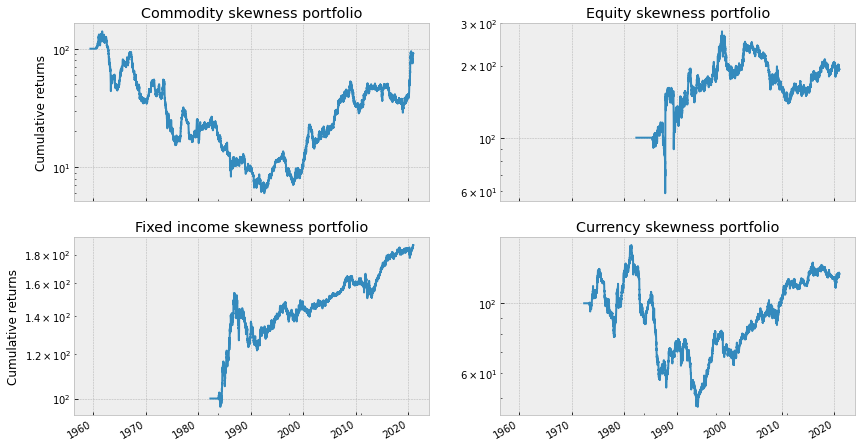

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
commodity_portfolio_return.plot(ax=ax[0][0], logy=True)
equity_portfolio_return.plot(ax=ax[0][1], logy=True)
fixed_income_portfolio_return.plot(ax=ax[1][0], logy=True)
currency_portfolio_return.plot(ax=ax[1][1], logy=True)

ax[0][0].set_title('Commodity skewness portfolio')
ax[0][1].set_title('Equity skewness portfolio')
ax[1][0].set_title('Fixed income skewness portfolio')
ax[1][1].set_title('Currency skewness portfolio')
ax[0][0].set_ylabel('Cumulative returns');
ax[1][0].set_ylabel('Cumulative returns');

In [13]:
pd.concat((
    commodity_portfolio_return.pipe(Performance).summary(),
    equity_portfolio_return.pipe(Performance).summary(),
    fixed_income_portfolio_return.pipe(Performance).summary(),
    currency_portfolio_return.pipe(Performance).summary(),
), axis=1)

,Commodity skewness portfolio,Equity skewness portfolio,Fixed income skewness portfolio,Currency skewness portfolio
annualised return,0.017624,0.033638,0.016991,0.008877
annualised vol,0.194905,0.186549,0.049913,0.094475
Sharpe ratio,0.090421,0.180319,0.340408,0.093964
max drawdown,0.957065,0.500381,0.209091,0.693606
Calmar ratio,0.018414,0.067225,0.081260,0.012799
skewness,-0.099994,4.212548,0.244651,-0.279412
kurtosis,4.608830,210.160725,6.040842,4.548794
worst return,-0.140897,-0.252194,-0.018644,-0.049846
worst 1d return,-0.140897,-0.252194,-0.018644,-0.049846
worst 1w return,-0.161193,-0.199777,-0.031681,-0.099163


## Performance since 1990
In the original paper, performance since 1990 is reported. The result below confirms that all skewness based portfolios exhibited positive performance over time.
Interestingly the equity portfolio somewhat performed weakly in the backtest. This could be due to the slightly different data set.

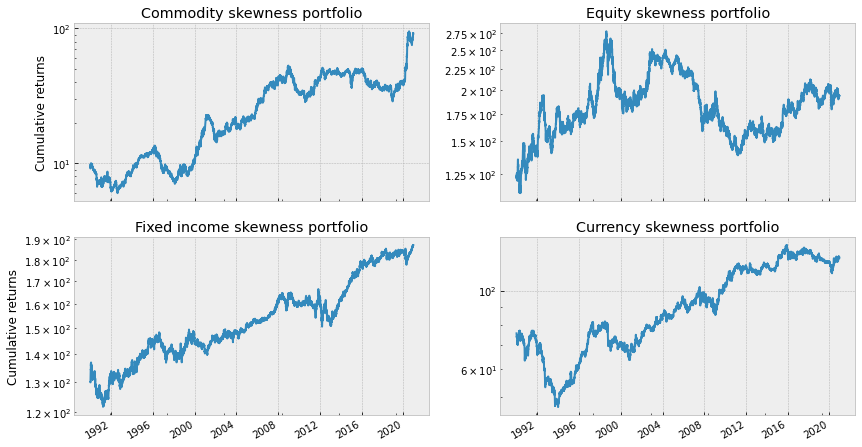

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
commodity_portfolio_return['1990':].plot(ax=ax[0][0], logy=True)
equity_portfolio_return['1990':].plot(ax=ax[0][1], logy=True)
fixed_income_portfolio_return['1990':].plot(ax=ax[1][0], logy=True)
currency_portfolio_return['1990':].plot(ax=ax[1][1], logy=True)

ax[0][0].set_title('Commodity skewness portfolio')
ax[0][1].set_title('Equity skewness portfolio')
ax[1][0].set_title('Fixed income skewness portfolio')
ax[1][1].set_title('Currency skewness portfolio')
ax[0][0].set_ylabel('Cumulative returns');
ax[1][0].set_ylabel('Cumulative returns');

## GSF
The authors defines the global skewness factor (GSF) by combining the 4 asset classes with equal vol weighting. Here, the 4 backtests are simply combined with each ex-post realised volatility.

In [15]:
def get_leverage(equity_curve: pd.Series) -> float:
    return 0.1 / (equity_curve.pct_change().std() * (252 ** 0.5))

In [16]:
gsf = pd.concat((
    commodity_portfolio_return.pct_change() * get_leverage(commodity_portfolio_return),
    equity_portfolio_return.pct_change() * get_leverage(equity_portfolio_return),
    fixed_income_portfolio_return.pct_change() * get_leverage(fixed_income_portfolio_return),
    currency_portfolio_return.pct_change() * get_leverage(currency_portfolio_return),
), axis=1).mean(axis=1)
gsf = gsf.fillna(0).add(1).cumprod().rename('GSF')

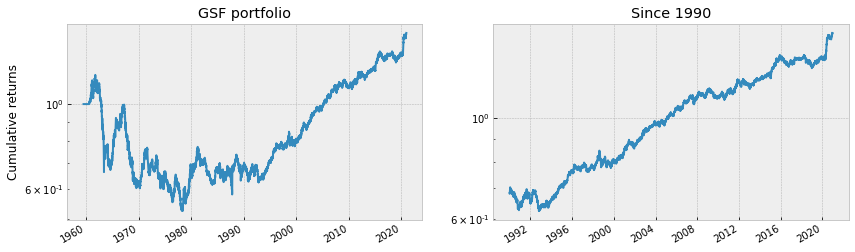

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
gsf.plot(ax=ax[0], logy=True);
gsf['1990':].plot(ax=ax[1], logy=True);
ax[0].set_title('GSF portfolio')
ax[1].set_title('Since 1990')
ax[0].set_ylabel('Cumulative returns');

In [18]:
pd.concat((
    gsf.pipe(Performance).summary(),
    gsf['1990':].pipe(Performance).summary().add_suffix(' (since 1990)')
), axis=1)

,GSF,GSF (since 1990)
annualised return,0.008869,0.026306
annualised vol,0.064036,0.044032
Sharpe ratio,0.138504,0.597432
max drawdown,0.559680,0.112029
Calmar ratio,0.015847,0.234815
skewness,0.020089,-0.227889
kurtosis,8.305385,2.923827
worst return,-0.037666,-0.025409
worst 1d return,-0.037666,-0.025409
worst 1w return,-0.075220,-0.027553


## Post publication

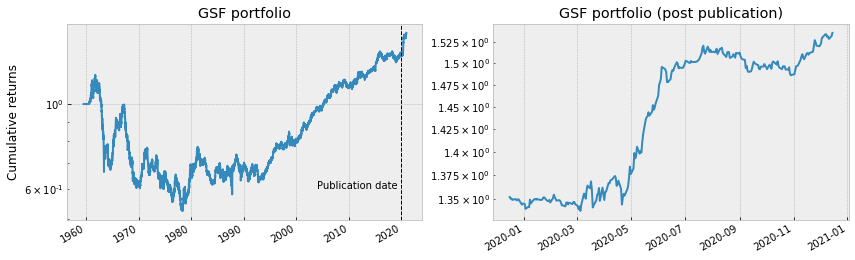

In [19]:
publication_date = datetime(2019, 12, 16)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
gsf.plot(ax=ax[0], logy=True);
ax[0].set_title('GSF portfolio')
ax[0].set_ylabel('Cumulative returns');
ax[0].axvline(publication_date, lw=1, ls='--', color='black')
ax[0].text(publication_date, 0.6, 'Publication date ', ha='right')

gsf.loc[publication_date:].plot(ax=ax[1], logy=True);
ax[1].set_title('GSF portfolio (post publication)');

## Recent performance

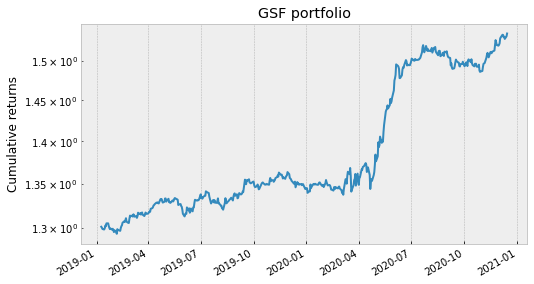

In [20]:
fig, ax = plt.subplots(figsize=(8, 4.5))
gsf.tail(252 * 2).plot(ax=ax, logy=True);
ax.set_title('GSF portfolio')
ax.set_ylabel('Cumulative returns');

# Reference
- Baltas, N. and Salinas, G., 2019. Cross-Asset Skew. Available at SSRN.

In [21]:
print(f'Updated: {datetime.utcnow().strftime("%d-%b-%Y %H:%M")}')

Updated: 16-Dec-2020 08:21
